<a href="https://colab.research.google.com/github/Sahel-Eskandar/Applied-ML/blob/main/Applied_Machine_Learning_Module_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

With the pre-processed data from the 'Simpsons_Data_Preprocessing' notebook, we are ready to build machine learning models that solve the classification problem.

# 1. Baseline model

A baseline model is used as a starting point for model performance comparison. You should aim to out perform the baseline model as much as you can. *(Note, as we are dealing with a balanced binary classification, a dummy classifier will give an accuracy of 0.5)*

# 2. Performance Improvement Methods
   
- Feature selection/processing     
    - Feature correlation
    - Imputation of NaN values    
    - Categorical Feature Encoding     
    - etc.
- Parameter tuning    
    - GridsearchCV    
    - etc.
- Model selection    
    - Logistic Regression      
    - Naive Bayes Classifier    
    - SVM    
    - Random Forest    
    - XGBoost    
    - etc.

# 3. Model Evaluation

As we are dealing with balanced binary classification problem, we can choose accuracy as our evaluation method. However you are more than welcome to explore other metrics as well.

- Accuracy
- Feature Importance Evaluation
- Ablation Analysis/Model Sensitivity/Occam's Razor 

# 4. Conclusion

Choose the model with best score based on your evaluation method (Note: the score should be cross validated, not a single output), and illustrate features the model weights *most* (e.g. top 10 features) and if there are interesting findings (e.g. unexpected feature that are heavily weighted by the model). 

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
X_all = pd.read_csv('/content/drive/MyDrive/Coursera/course3/resources/course3/assets/X_all.csv', index_col=0)
y_all = pd.read_csv('/content/drive/MyDrive/Coursera/course3/resources/course3/assets/y_all.csv', index_col=0)

In [32]:
#X_all.info(verbose=True)
X_all.info(verbose= True,max_cols=30,memory_usage='deep')
#X_all.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 0 to 599
Data columns (total 307 columns):
 #    Column                       Dtype  
---   ------                       -----  
 0    episode_id                   int64  
 1    10-Year-Old Homer            float64
 2    ARTIE                        float64
 3    Agnes Skinner                float64
 4    Akira                        float64
 5    Alec Baldwin                 float64
 6    Alex                         float64
 7    All                          float64
 8    Amber Dempsey                float64
 9    Annie Crawford               float64
 10   Announcer                    float64
 11   Apu Nahasapeemapetilon       float64
 12   Armin                        float64
 13   Arnie Pye                    float64
 14   Artie Ziff                   float64
 15   Attendant                    float64
 16   Auctioneer                   float64
 17   Audience                     float64
 18   Avatar Bart                 

**Imputation option:**

- fillna with 0.0
- fillna with median 
- fillna with mean

In [33]:
X_all[['original_air_year', 'season']].corr()

,original_air_year,season
original_air_year,1.00000,0.99803
season,0.99803,1.00000


In [34]:
# X_all = X_all.drop('season',1)
# including both 'season' and 'original_air_year' actually boosted model performance in general even they are highly correlated

In [35]:
col_mean = X_all.mean()
col_med = X_all.median()

X_all_imputed_mean = X_all.fillna(col_mean)
X_all_imputed_zero = X_all.fillna(0.0)
X_all_imputed_median = X_all.fillna(col_med)

In [36]:
# Manual Feature Selection based on number of lines character have spoken across all seasons

top_columns = ['episode_id','number_in_season', 'number_in_series', 'season',
               'original_air_year', 'us_viewers_in_millions', 'views',
               'Homer Simpson', 'Marge Simpson', 'Bart Simpson', 'Lisa Simpson',
               'C. Montgomery Burns', 'Moe Szyslak', 'Seymour Skinner', 'Ned Flanders',
               'Grampa Simpson', 'Milhouse Van Houten', 'Chief Wiggum',
               'Krusty the Clown', 'Nelson Muntz', 'Lenny Leonard',
               'Apu Nahasapeemapetilon', 'Waylon Smithers', 'Kent Brockman',
               'Carl Carlson', 'Edna Krabappel-Flanders', 'Dr. Julius Hibbert']

# 1. Logistic Regression (accuracy: 0.83 - 0.863)

In [37]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

from sklearn.model_selection import cross_validate, KFold


In [38]:
def performance_graphics(thresholds, thresholds_roc, precision, recall, fp, tp, auc_score):


    close_default = np.argmin(np.abs(thresholds - 0.5))
    close_zero = np.argmin(np.abs(thresholds_roc))

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 4))

    ax1.plot(precision, recall, label="Precision Recall Curve")
    ax1.plot(precision[close_default], 
             recall[close_default], 'o', 
             c='r', markersize=10, 
             label='threshold 0.5', 
             fillstyle="none", mew=2)
    ax1.set_title("RF performance")
    ax1.set_xlabel("Precision")
    ax1.set_ylabel("Recall")
    ax1.legend(loc='best')

    ax2.plot(fp, tp, label="ROC curve")
    ax2.plot(fp[close_zero], 
             tp[close_zero], 'o', 
             c='r', markersize=10, 
             label='threshold 0', 
             fillstyle="none", mew=2)
    ax2.set_title(f"ROC performance: AUC Score {auc_score}")
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive (Recall)")
    ax2.legend(loc='best')
    
    return fig

def classifier_assessment(X, y, clf, show_graph=True):
    """
    args: X dataset of features
          y target set of values for classification

    returns: 
        - the mean of the Logistic Regression Claffifier prediction scores taken from a 
          5 fold cross validation on the dataset
    """
    kfold = KFold(n_splits=5)
    cross_val = cross_validate(clf, X, y, cv=kfold, return_estimator=True)
    mean_score = cross_val['test_score'].mean()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    clf.fit(X_train, y_train)
    proba_ = clf.predict_proba(X_test)[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(y_test, proba_)
    fp, tp, thresholds_roc = roc_curve(y_test, proba_)

    auc_score = np.round(roc_auc_score(y_test, proba_), 4)
    
    # this will plot graph automatically
    if show_graph:
        performance_graphics(thresholds, thresholds_roc, precision, recall, fp, tp, auc_score)

    return mean_score, clf

0.85

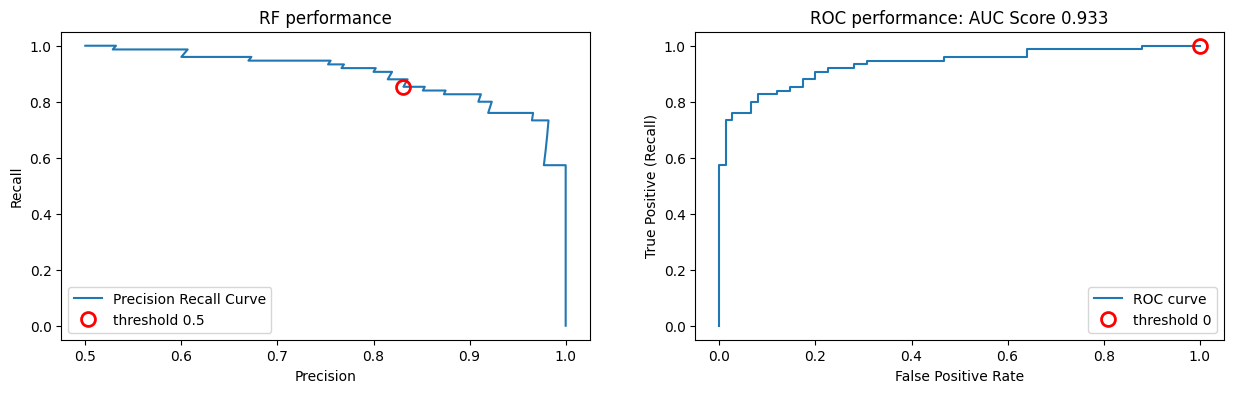

In [39]:
np.random.seed(0)

import warnings
warnings.filterwarnings("ignore")

clf_log = LogisticRegression(random_state=0)
mean_score, clf_log = classifier_assessment(X_all_imputed_mean, y_all, clf=clf_log)
mean_score 

0.8316666666666667

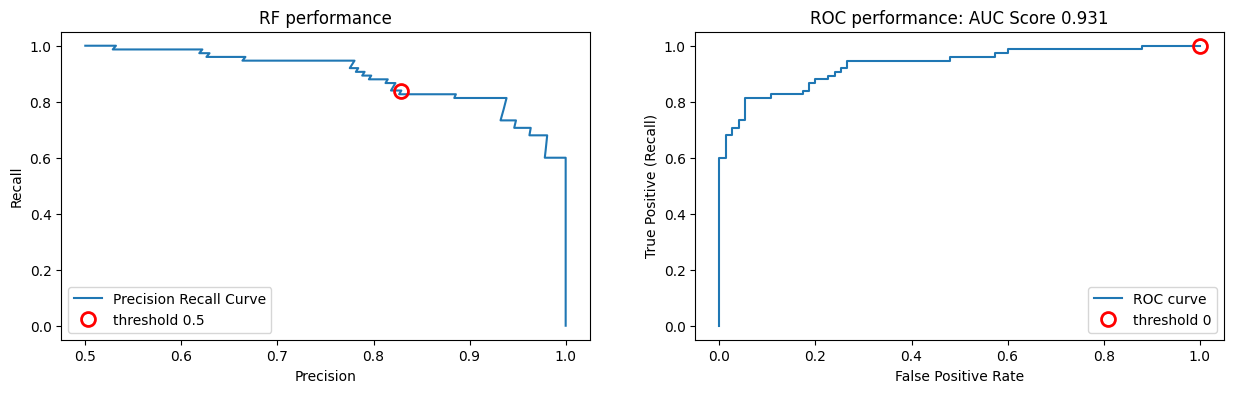

In [40]:
# when impute with 0, mean accuracy is not as good, though ROC score is higher.
clf_log2 = LogisticRegression(random_state=0)
mean_score, clf_log2 = classifier_assessment(X_all_imputed_zero, y_all, clf=clf_log2)
mean_score 

0.8533333333333333

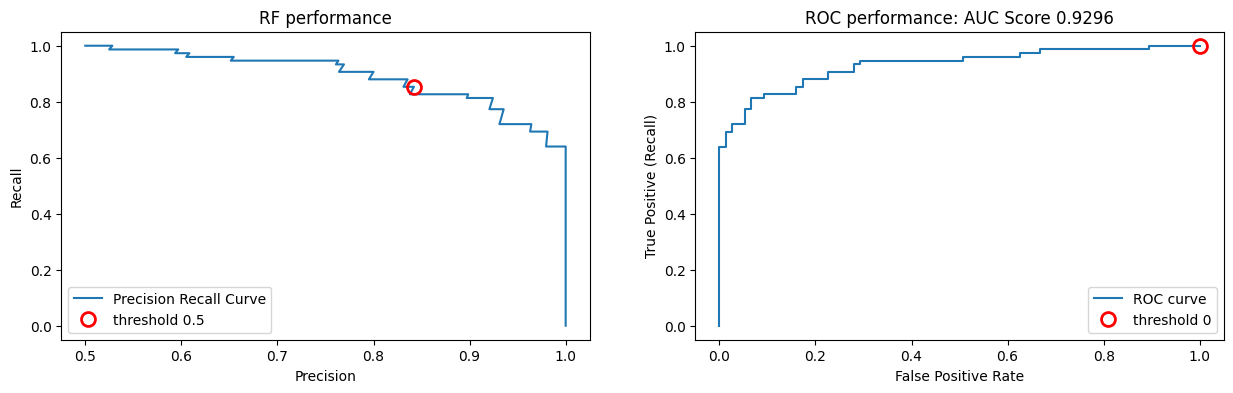

In [41]:
# when impute with median the result is not as good but better than 0
clf_log3 = LogisticRegression(random_state=0)
mean_score, clf_log3 = classifier_assessment(X_all_imputed_median, y_all, clf=clf_log3)
mean_score

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [43]:
pipe = Pipeline([('classifier' , LogisticRegression(random_state=1))])
param_grid = [
    {'classifier' : [LogisticRegression(random_state=1)],
     'classifier__penalty' : ['l1', 'l2'],
     'classifier__C' : np.logspace(-4, 4, 20), # we mainly evaluate parameter C for LR
     'classifier__solver' : ['liblinear']}]

clf_cv = GridSearchCV(pipe, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)
X_train, X_test, y_train, y_test = train_test_split(X_all_imputed_median, y_all['popularity_class'].ravel(), random_state=1)
clf_cv = clf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [44]:
clf_cv.best_params_

{'classifier': LogisticRegression(C=0.00026366508987303583, random_state=1, solver='liblinear'),
 'classifier__C': 0.00026366508987303583,
 'classifier__penalty': 'l2',
 'classifier__solver': 'liblinear'}

0.865

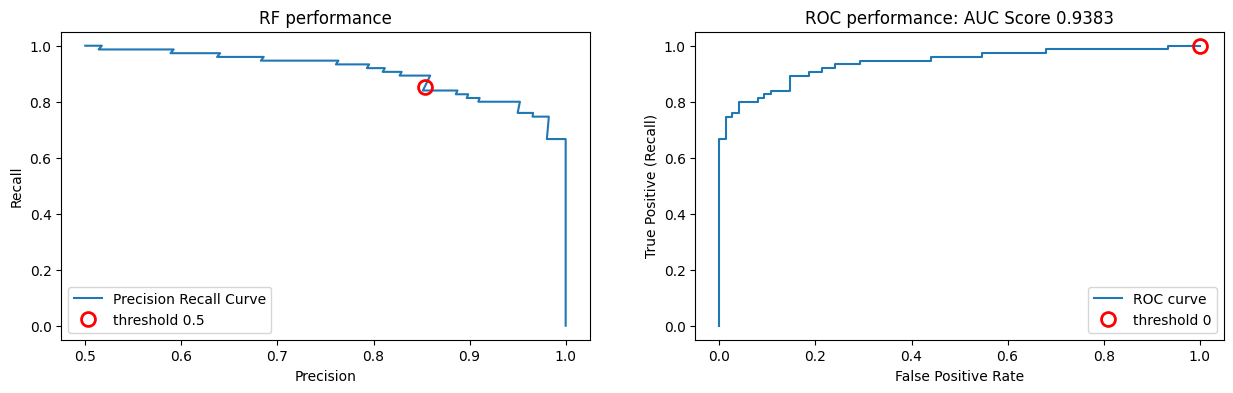

In [45]:
clf_log_best = LogisticRegression(C=clf_cv.best_params_['classifier__C'], 
                                  random_state=1, 
                                  solver=clf_cv.best_params_['classifier__solver'])
mean_score, clf_log_best = classifier_assessment(X_all_imputed_median, 
                                                 y_all, 
                                                 clf=clf_log_best)

mean_score

## Feature analysis

In [46]:
def feat_importance_eval(clf, columns=X_all.columns):
    try:
        importances = clf.feature_importances_
    except:
        importances = clf.coef_[0]
        
    importance_dict = {}
    for importance, name in zip(importances, columns):
        if importance!=0:
            importance_dict[name]=importance
            
    importance_dict = sorted(importance_dict.items(), key=lambda x: -x[-1])[:10]
    return importance_dict

def plot_feature_importance(importance_dict):
    plt.figure(figsize=(15,6));
    x_label = [x[0] for x in importance_dict]
    x_coords = list(range(len(importance_dict)))
    plt.bar(x=x_coords, 
            width=0.5,
            height=[x[-1] for x in importance_dict],
            tick_label=x_label);

    ax = plt.gca()
    ax.set_xticklabels(rotation=45, labels=x_label);

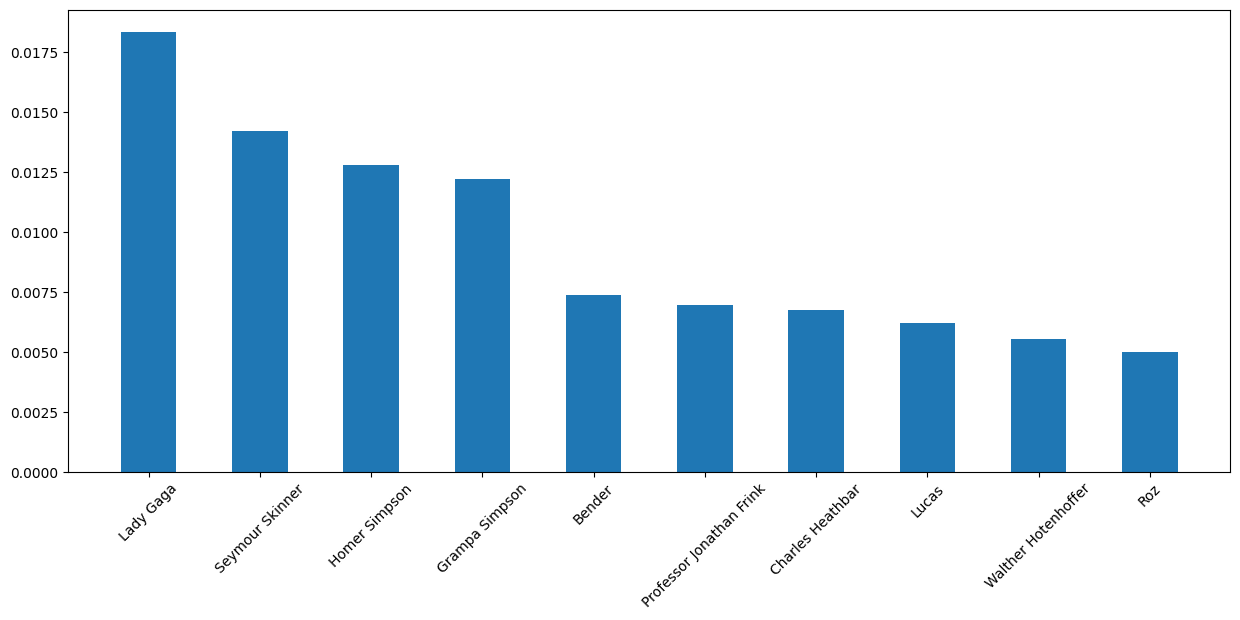

In [47]:
importance_dict_lr = feat_importance_eval(clf_log_best)
plot_feature_importance(importance_dict_lr)

### Try remove the most important feature and see how it affect accuracy

0.845

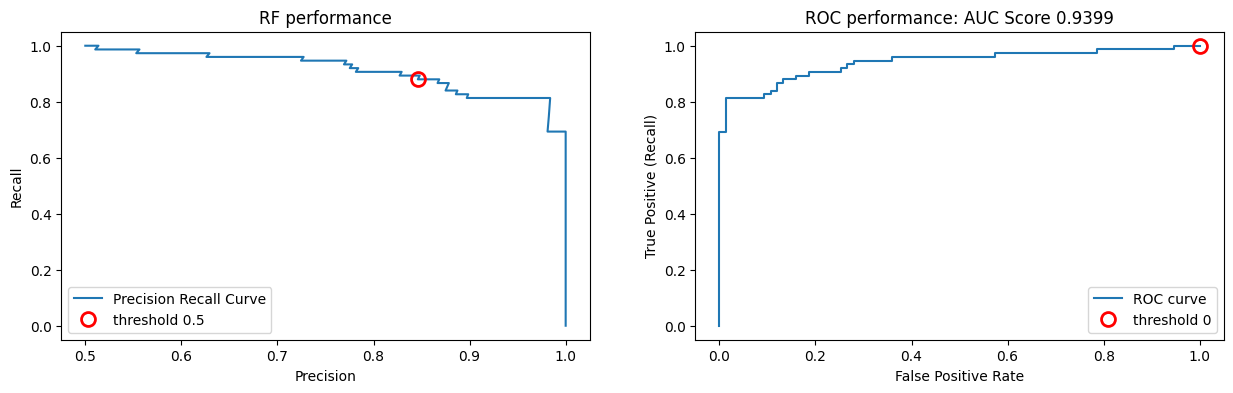

In [48]:
X_all_ablation = X_all_imputed_median.drop('Homer Simpson',1)

clf_log_best2 = LogisticRegression(C=clf_cv.best_params_['classifier__C'], 
                                  random_state=1, 
                                  solver=clf_cv.best_params_['classifier__solver'])

mean_score, clf_log_best2 = classifier_assessment(X_all_ablation, 
                                                  y_all, 
                                                  clf=clf_log_best2)
mean_score

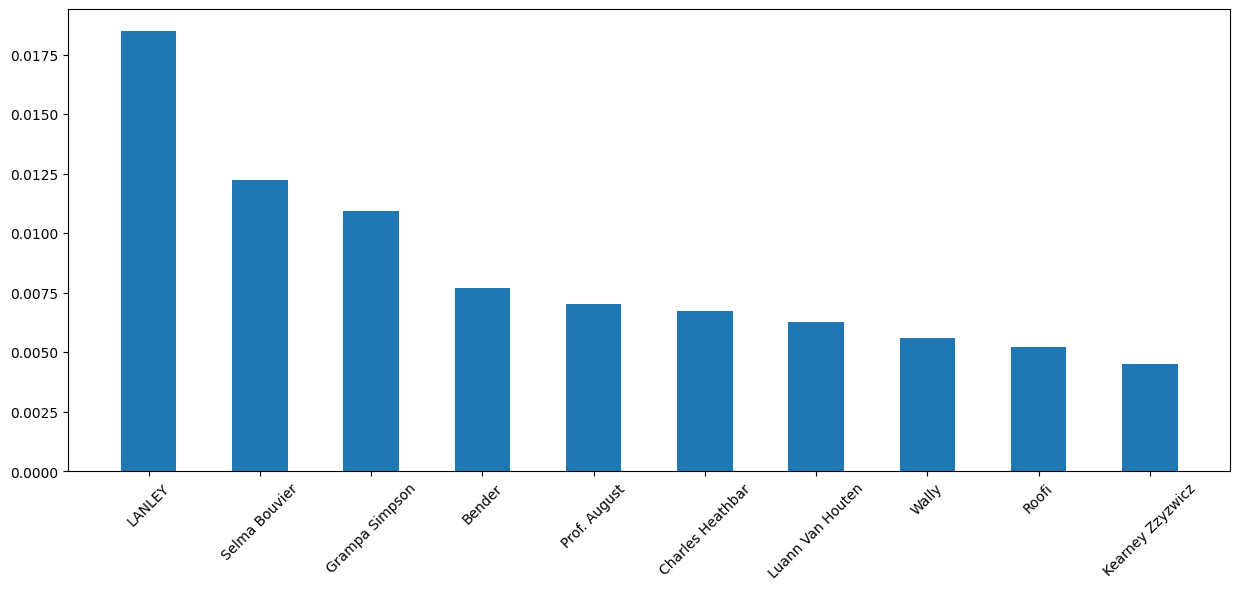

In [49]:
importance_dict_lr2 = feat_importance_eval(clf_log_best2)
plot_feature_importance(importance_dict_lr2)

### Try if we only use episode features

0.8433333333333334

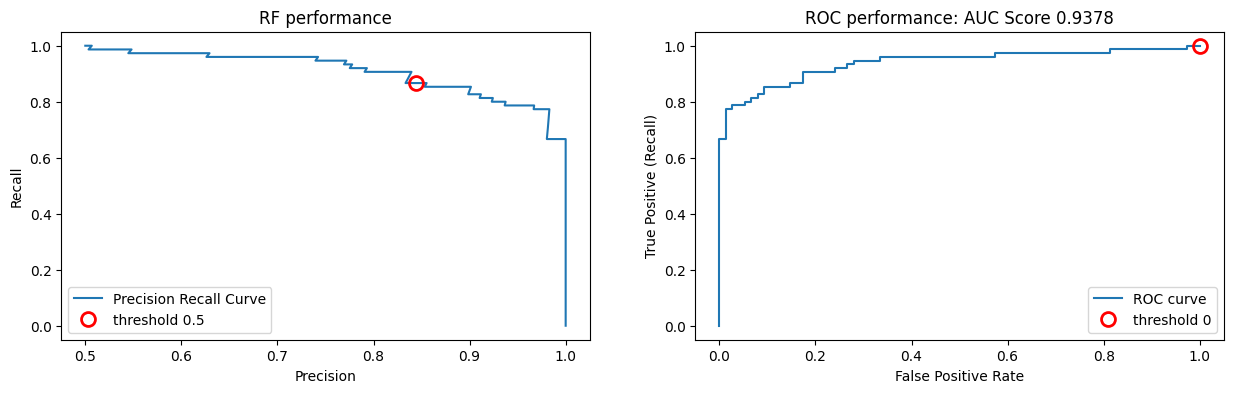

In [50]:
episode_columns = ['episode_id','number_in_season', 'number_in_series', 'season', 
                   'original_air_year', 'us_viewers_in_millions', 'views',]

X_all_ablation = X_all_imputed_median[episode_columns]
clf_log_best2 = LogisticRegression(C=clf_cv.best_params_['classifier__C'], 
                                  random_state=1, 
                                  solver=clf_cv.best_params_['classifier__solver'])

mean_score, clf_log_best2 = classifier_assessment(X_all_ablation, 
                                                  y_all, 
                                                  clf=clf_log_best2)

mean_score

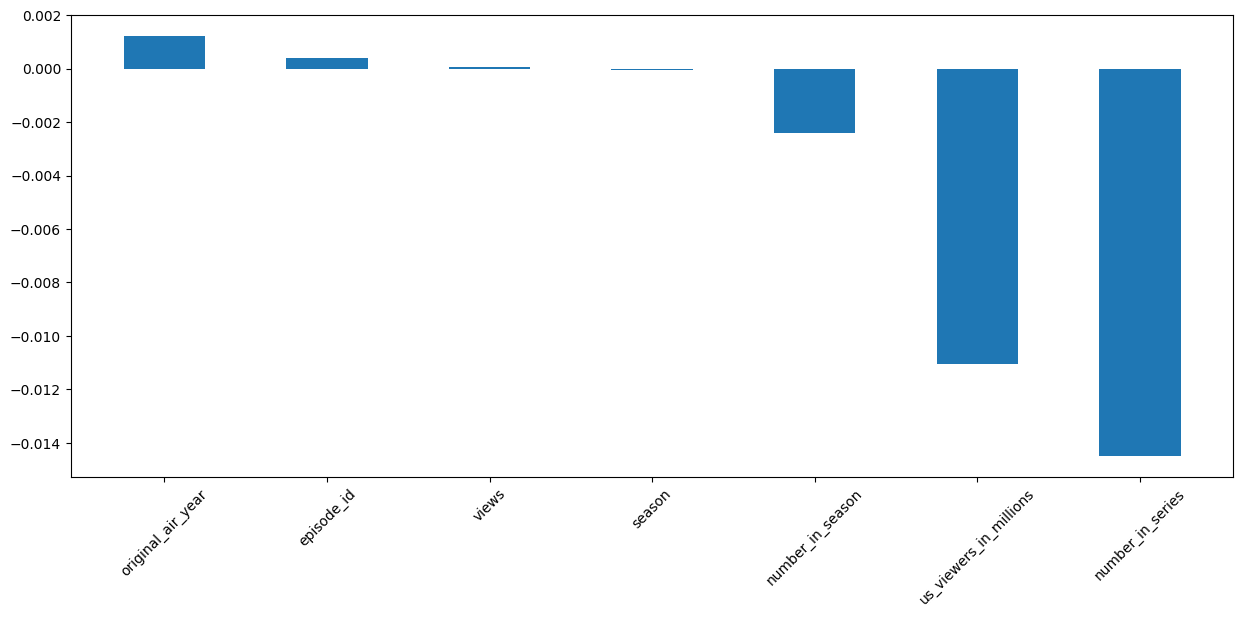

In [51]:
importance_dict_lr2 = feat_importance_eval(clf_log_best2, columns=episode_columns)
plot_feature_importance(importance_dict_lr2)

In [52]:
importance_dict_lr2

[('original_air_year', 0.001224937214089795),
 ('episode_id', 0.0003991478002960293),
 ('views', 4.115098525684703e-05),
 ('season', -4.215750959468459e-05),
 ('number_in_season', -0.002425171958379856),
 ('us_viewers_in_millions', -0.011055735870294615),
 ('number_in_series', -0.014481061907211766)]

# 2. Naive Bayes Classifier (accuracy: 0.645 - 0.833)

In [53]:
from sklearn.naive_bayes import GaussianNB

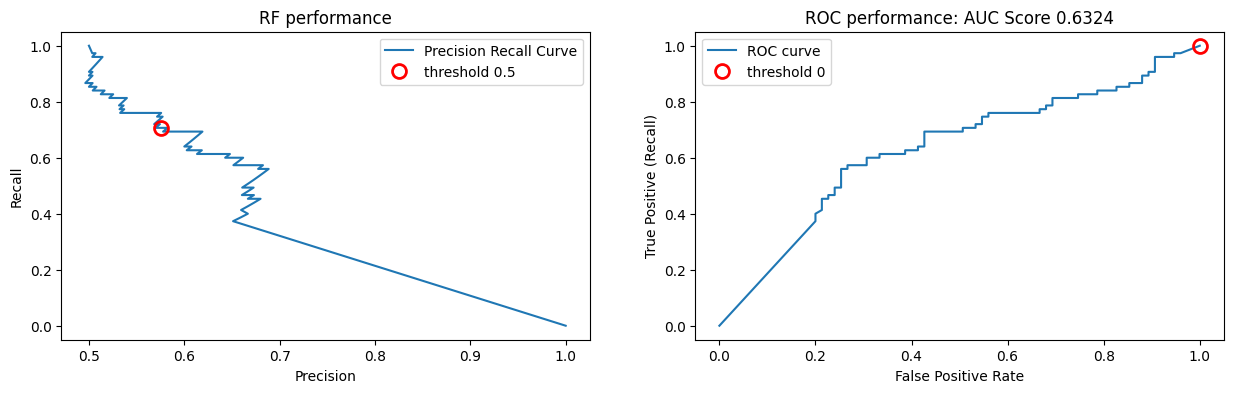

In [54]:
clf_nb = GaussianNB(priors=None)
mean_score, clf_nb = classifier_assessment(X_all_imputed_median, y_all, clf=clf_nb)

In [55]:
mean_score

0.645

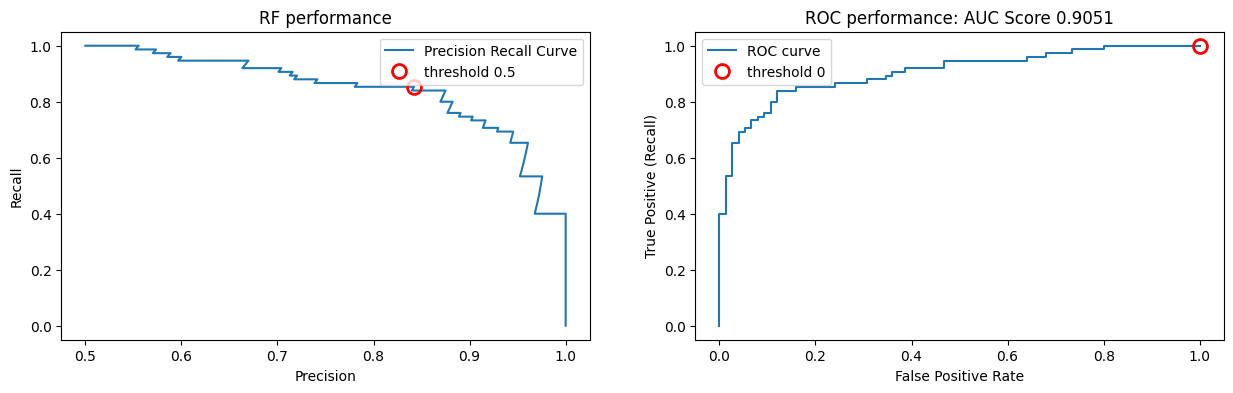

In [56]:
clf_nb = GaussianNB(priors=None)
mean_score, clf_nb = classifier_assessment(X_all[top_columns].fillna(0.0), y_all, clf=clf_nb)

In [57]:
mean_score

0.8283333333333334

0.8333333333333333

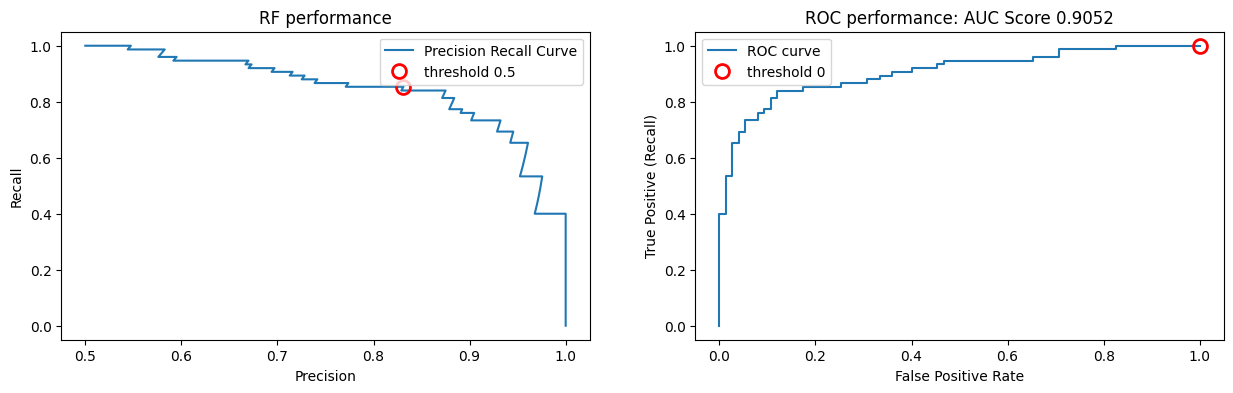

In [58]:
clf_nb = GaussianNB(priors=None)
mean_score, clf_nb = classifier_assessment(X_all[top_columns].fillna(X_all[top_columns].median()), y_all, clf=clf_nb)
mean_score

# 3. Random Forest (accuracy: 0.867 - 0.878)

In [59]:
from sklearn.ensemble import RandomForestClassifier

0.8666666666666666

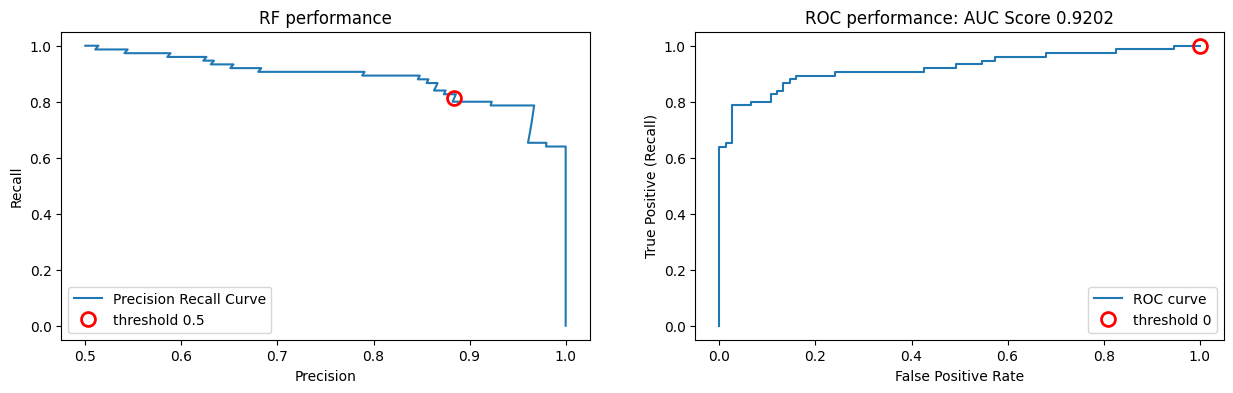

In [60]:
clf_rf = RandomForestClassifier(max_depth=11, random_state=0)
mean_score, clf_rf = classifier_assessment(X_all_imputed_median, y_all, clf=clf_rf)
mean_score

0.8683333333333334

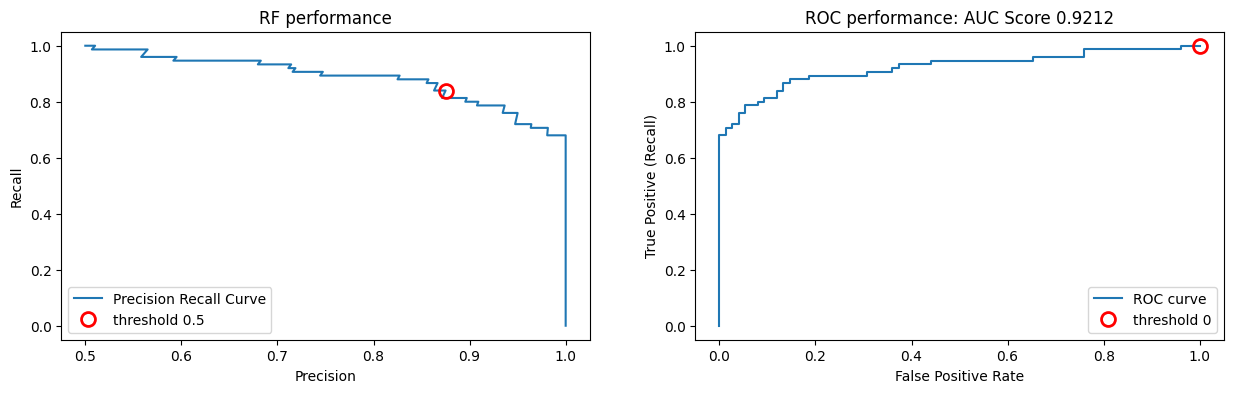

In [61]:
clf_rf2 = RandomForestClassifier(max_depth=11, random_state=0)
mean_score, clf_rf2 = classifier_assessment(X_all_imputed_mean, y_all, clf=clf_rf2)
mean_score

0.875

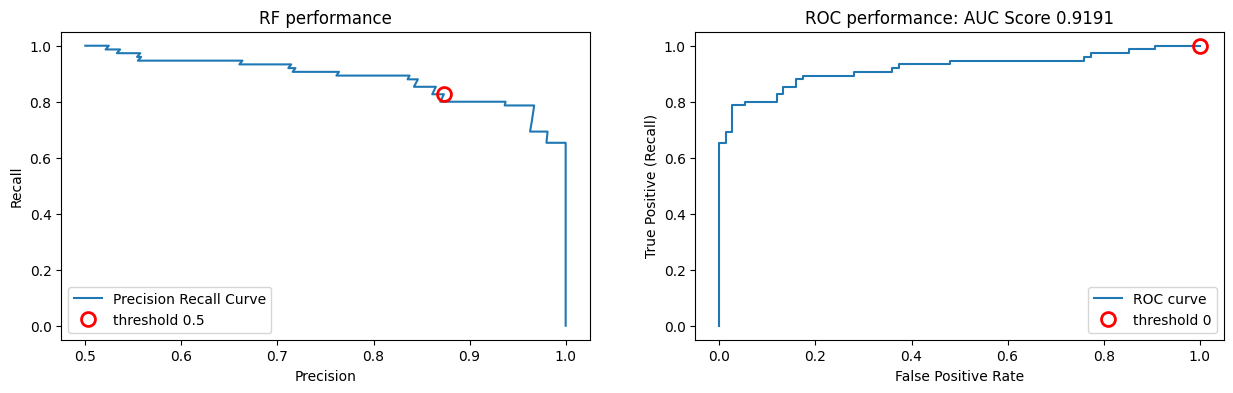

In [62]:
clf_rf3 = RandomForestClassifier(max_depth=11, random_state=0)
mean_score, clf_rf3 = classifier_assessment(X_all_imputed_zero, y_all, clf=clf_rf3)
mean_score

0.8783333333333333

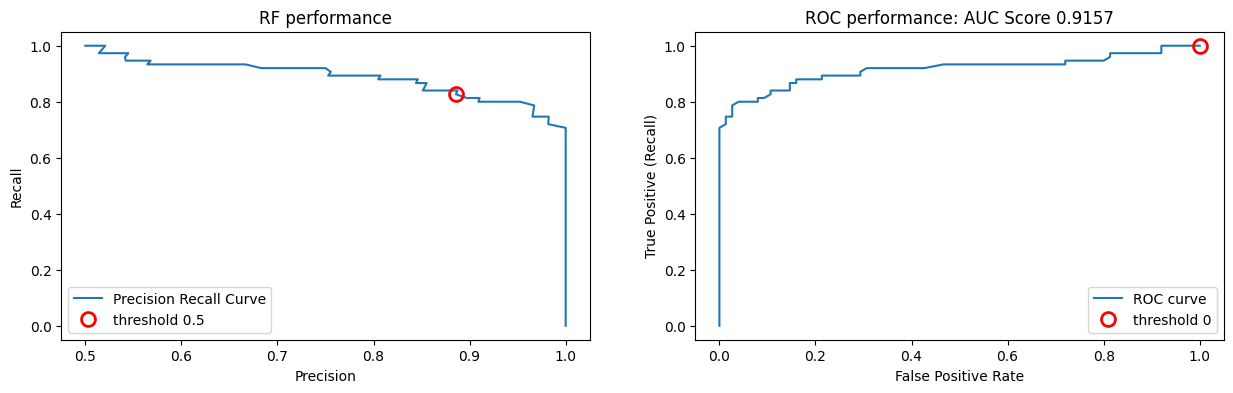

In [63]:
clf_rf3 = RandomForestClassifier(max_depth=20, random_state=0)
mean_score, clf_rf3 = classifier_assessment(X_all_imputed_zero, y_all, clf=clf_rf3)
mean_score

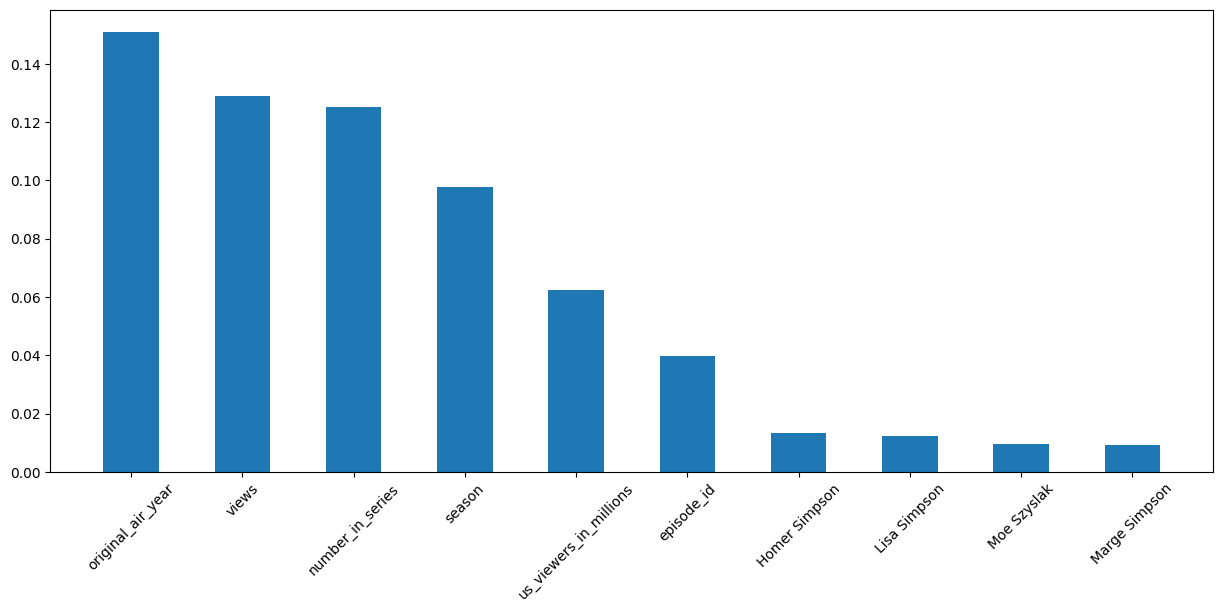

In [64]:
# feature_importance
importance_dict_rf = feat_importance_eval(clf_rf)
plot_feature_importance(importance_dict_rf)

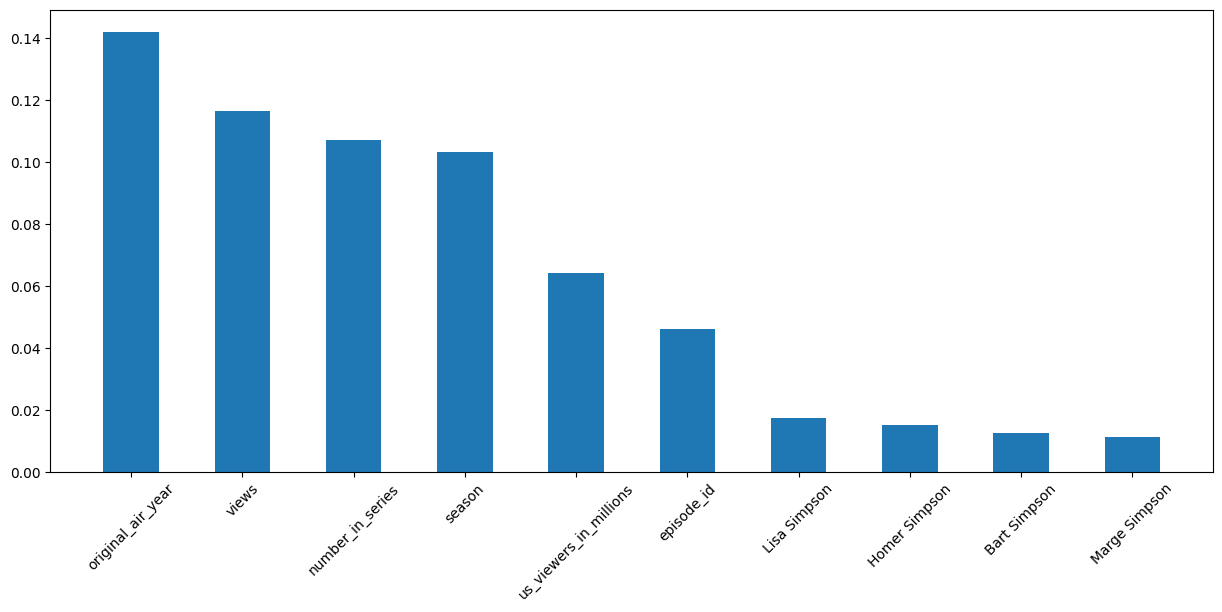

In [65]:
# feature_importance
importance_dict_rf3 = feat_importance_eval(clf_rf3)
plot_feature_importance(importance_dict_rf3)

# 4. SVM (accuracy score: 0.56 - 0.825)

0.5599999999999999

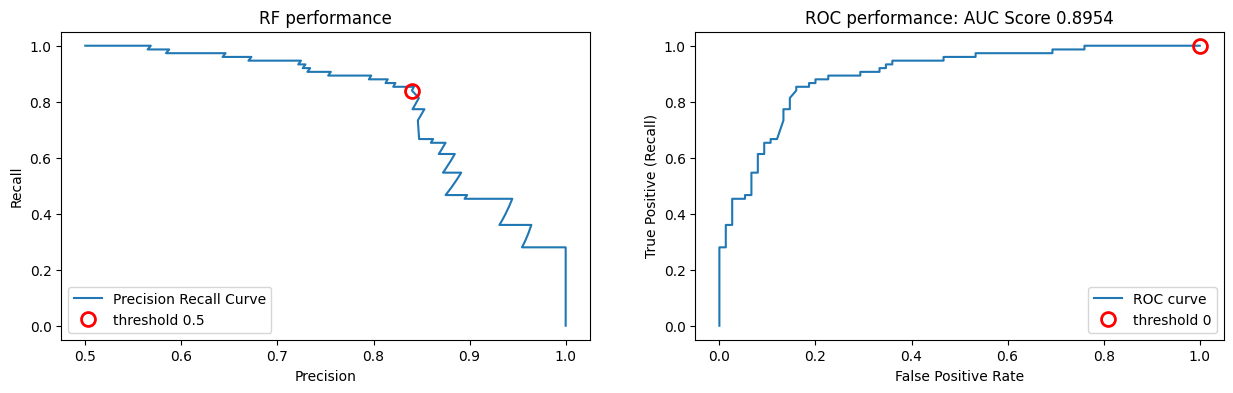

In [66]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf_svc = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
mean_score, clf_svc = classifier_assessment(X_all_imputed_median, y_all, clf=clf_svc)
mean_score

0.8233333333333333

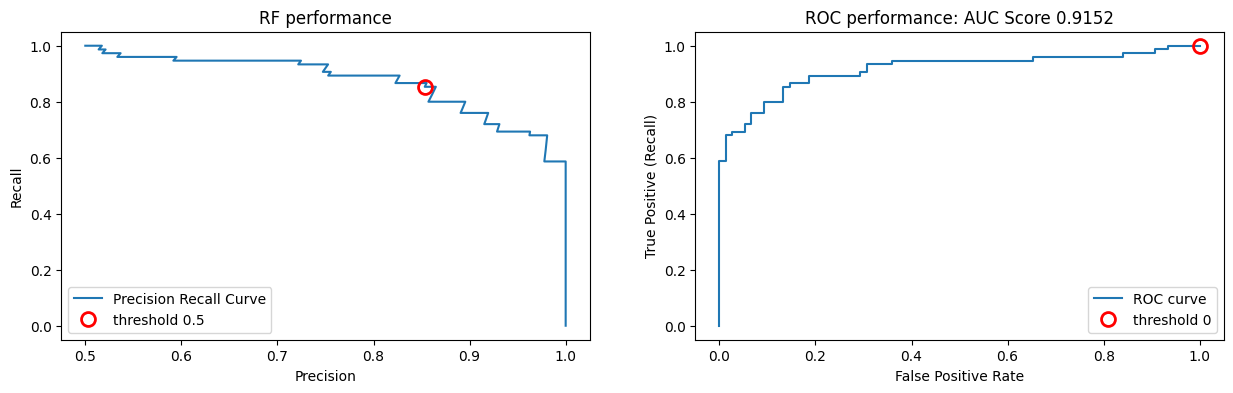

In [67]:
# less column make better predictions
clf_svc = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
mean_score, clf_svc = classifier_assessment(X_all[top_columns].fillna(0.0), y_all, clf=clf_svc)
mean_score

0.825

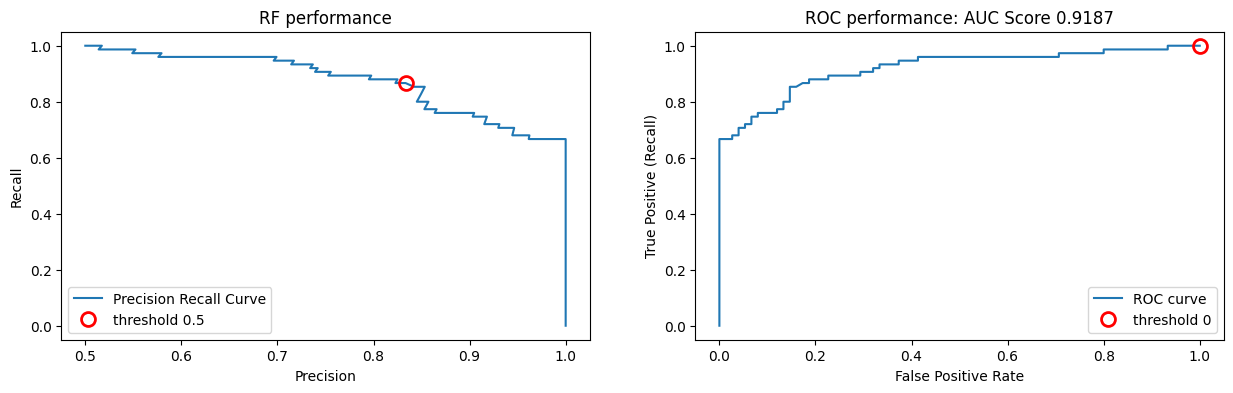

In [68]:
clf_svc = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
mean_score, clf_svc = classifier_assessment(X_all[top_columns].fillna(X_all[top_columns].mean()), y_all, clf=clf_svc)
mean_score

# 5. XGBoost (accuracy score: 0.86 - 0.88)

0.8616666666666667

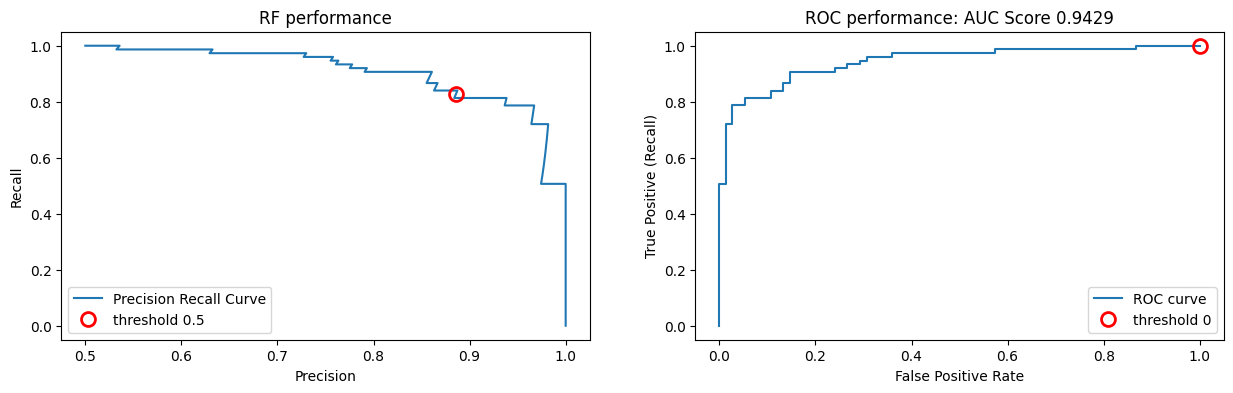

In [69]:
import xgboost as xgb

xgb_cl = xgb.XGBClassifier(eval_metric='mlogloss')
mean_score, clf_xgb = classifier_assessment(X_all_imputed_median.astype(float), y_all, clf=xgb_cl)
mean_score

In [70]:
param_grid = {
    "max_depth": [1, 3, 5],
    "learning_rate": [0.1, 0.05, 0.01],
    "gamma": [0, 0.25, 1, 10, 20],
    "reg_lambda": [0, 1, 10, 30, 50],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

In [71]:
from sklearn.model_selection import GridSearchCV
import time

start_time = time.process_time() # evaluate cpu process time in seconds

xgb_cl = xgb.XGBClassifier(eval_metric='mlogloss')
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="accuracy")
_ = grid_cv.fit(X_all.fillna(0.0), y_all)


end_time = time.process_time()

print('Cross validation took time:', end_time-start_time)

Cross validation took time: 14.187185145


In [72]:
best_params = grid_cv.best_params_
best_params

{'colsample_bytree': 0.5,
 'gamma': 10,
 'learning_rate': 0.05,
 'max_depth': 1,
 'reg_lambda': 30,
 'scale_pos_weight': 1,
 'subsample': 0.8}

In [73]:
best_xgb = xgb.XGBClassifier(colsample_bytree=best_params['colsample_bytree'],
                             gamma=best_params['gamma'],
                             learning_rate=best_params['learning_rate'],
                             max_depth=best_params['max_depth'],
                             reg_lambda=best_params['reg_lambda'],
                             scale_pos_weight=best_params['scale_pos_weight'],
                             subsample=best_params['subsample'],
                             eval_metric='mlogloss',)

0.8783333333333332

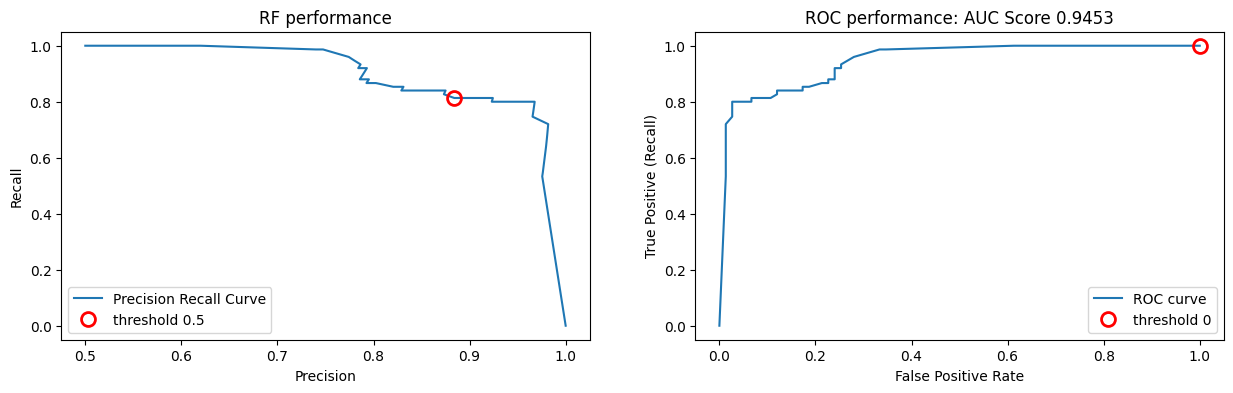

In [74]:
mean_score, clf_xgb = classifier_assessment(X_all.fillna(0.0), y_all, clf=best_xgb)
mean_score

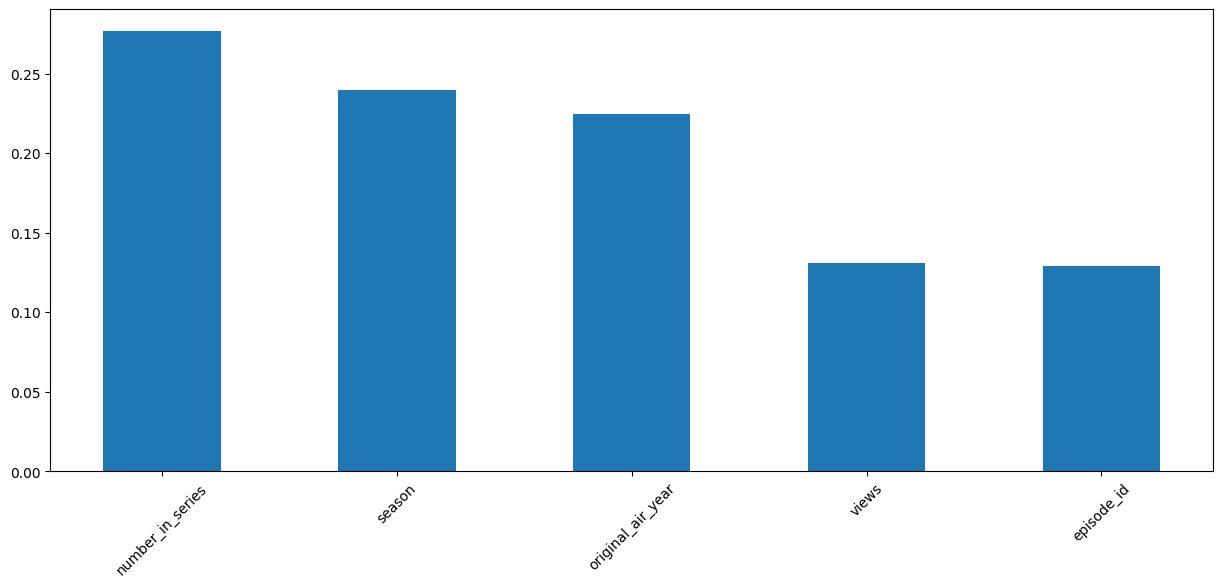

In [75]:
importance_dict_xgb = feat_importance_eval(clf_xgb)
plot_feature_importance(importance_dict_xgb)

Training XGBoost with all features took time: 3.2945322400000094


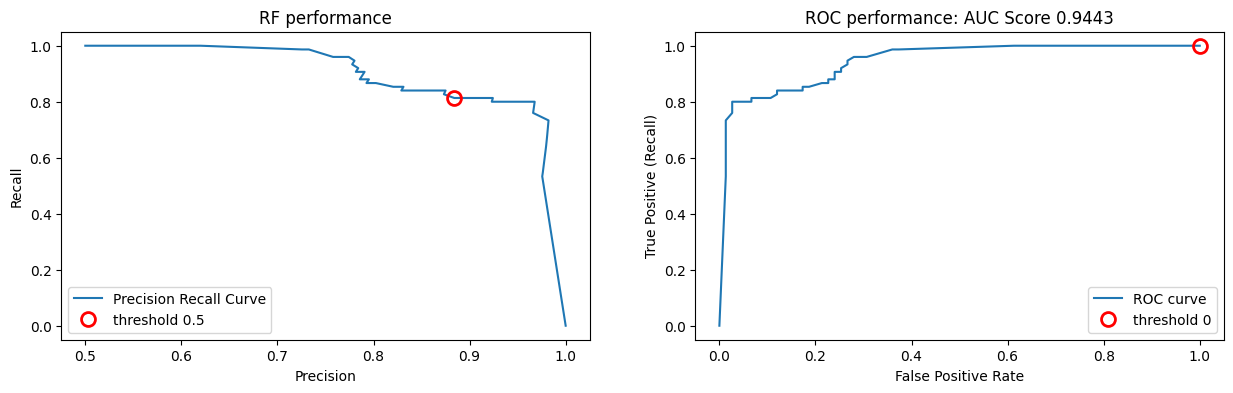

In [76]:
start_time = time.process_time()
mean_score, clf_xgb2 = classifier_assessment(X_all_imputed_median.astype(float), y_all, clf=best_xgb)
end_time = time.process_time()

print('Training XGBoost with all features took time:', end_time-start_time)

In [77]:
mean_score

0.8783333333333332

0.8766666666666666

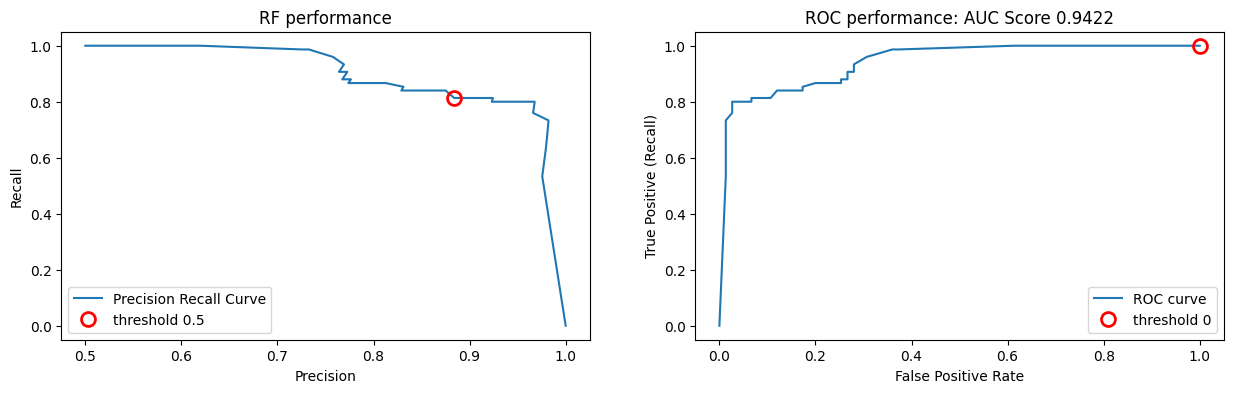

In [78]:
mean_score, clf_xgb2 = classifier_assessment(X_all_imputed_mean.astype(float), y_all, clf=best_xgb)
mean_score

Training XGBoost with only top features took time: 0.8846040869999996


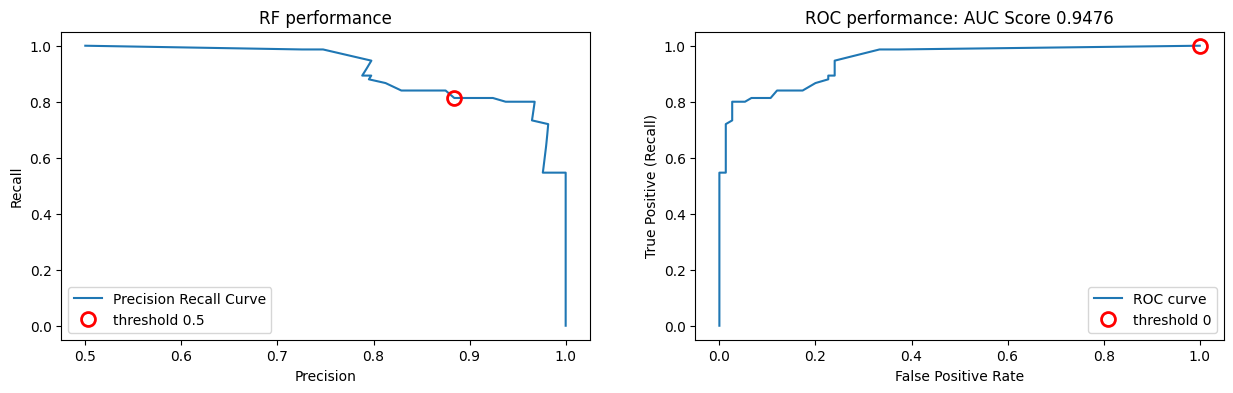

In [79]:
start_time = time.process_time()
mean_score, clf_xgb2 = classifier_assessment(X_all_imputed_median[top_columns].astype(float), 
                                             y_all['popularity_class'].ravel(), 
                                             clf=best_xgb)
end_time = time.process_time()

print('Training XGBoost with only top features took time:', end_time-start_time)

In [80]:
mean_score

0.8766666666666666

# Conclusion

**Best performing model is XGBoost with Median Imputation and gridsearchcv (parameter tuning), average accuracy for the model is 0.88167.**